Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [185]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.datasets import load_digits
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure, v_measure_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

import numpy as np
from tqdm import tqdm

digits = load_digits()


X = digits.data
y = digits.target
print(f"X.shape: {X.shape}\ny.shape: {y.shape}")

X.shape: (1797, 64)
y.shape: (1797,)


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

<Figure size 432x288 with 0 Axes>

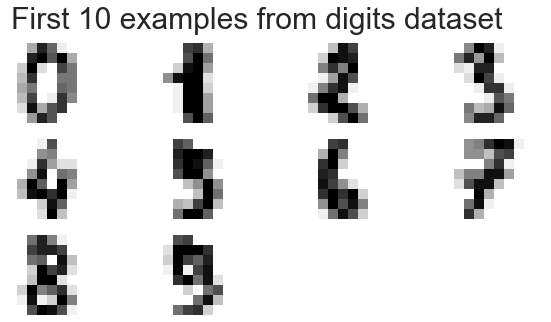

In [186]:
def invert_color(image):
    return (image - 16) * -1

def clean_image(ax):
    ax.axis('off')
    ax.tick_params(
        axis='both',         
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelleft=False,
        labelbottom=False) # labels along the bottom edge are off

def plot_digits(rows, columns, num_of_pictures, images, title, figsize=(10, 5), interpolation=None):
    plt.gray()
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    for i in range(rows):
        for j in range(columns):
            clean_image(axs[i, j])
            if i * columns + j < num_of_pictures:
                axs[i, j].imshow(invert_color(images[i * columns + j]), interpolation=None)
    plt.suptitle(title, fontsize=30)
    plt.show()

plot_digits(rows=3, columns=4, num_of_pictures=10, images=digits.images, title="First 10 examples from digits dataset")

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [187]:
N_CLUSTERS = 10

In [188]:
kmeans = KMeans(n_clusters = N_CLUSTERS, n_init = 100).fit(X)
hierarchical = AgglomerativeClustering(n_clusters = N_CLUSTERS).fit(X)

print(f"kmeans labels shape: {kmeans.labels_.shape}")
print(f"hierarchical labels shape: {hierarchical.labels_.shape}")

kmeans labels shape: (1797,)
hierarchical labels shape: (1797,)


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [189]:
def calculate_centers(X, labels, nclusters, pixels):
    centers = np.zeros((nclusters, pixels))
    for cluster in range(nclusters):
        centers[cluster, :] = np.mean(X[labels == cluster], axis=0)
    return centers

In [190]:
kmeans_centers = calculate_centers(X, kmeans.labels_, N_CLUSTERS, pixels=64)
hierarchical_centers = calculate_centers(X, hierarchical.labels_, N_CLUSTERS, pixels=64)

# let's check on kmeans centers, that we calculated it correct
assert(np.allclose(kmeans_centers, kmeans.cluster_centers_))

<Figure size 432x288 with 0 Axes>

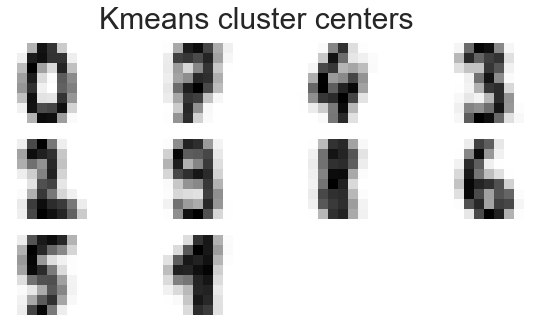

In [191]:
plot_digits(rows=3,
            columns=4,
            num_of_pictures=10,
            images=kmeans_centers.reshape(10, 8, 8),
            title="Kmeans cluster centers",
            figsize=(10, 5))

<Figure size 432x288 with 0 Axes>

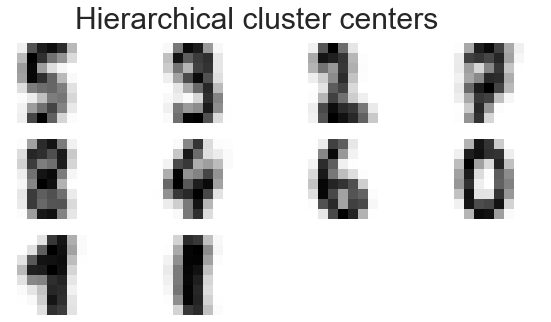

In [192]:
plot_digits(rows=3,
            columns=4,
            num_of_pictures=10,
            images=hierarchical_centers.reshape(10, 8, 8),
            title="Hierarchical cluster centers",
            figsize=(10, 5))

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [193]:
silhouette_scores_kmeans = []
silhouette_scores_hierarchical = []
# calculate entropy metrics here as well - in one run
entropy_metrics_kmeans = []
entropy_metrics_hierarchical = []
clusters = np.arange(2, 21)

for k in tqdm(clusters, desc='clusters'):
    kmeans = KMeans(n_clusters = k, n_init = 100).fit(X)
    hierarchical = AgglomerativeClustering(n_clusters = k).fit(X)
    silhouette_scores_kmeans.append(silhouette_score(X, kmeans.labels_))
    silhouette_scores_hierarchical.append(silhouette_score(X, hierarchical.labels_))
    entropy_metrics_kmeans.append(homogeneity_completeness_v_measure(y, kmeans.labels_))
    entropy_metrics_hierarchical.append(homogeneity_completeness_v_measure(y, hierarchical.labels_))

clusters: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:30<00:00,  1.60s/it]


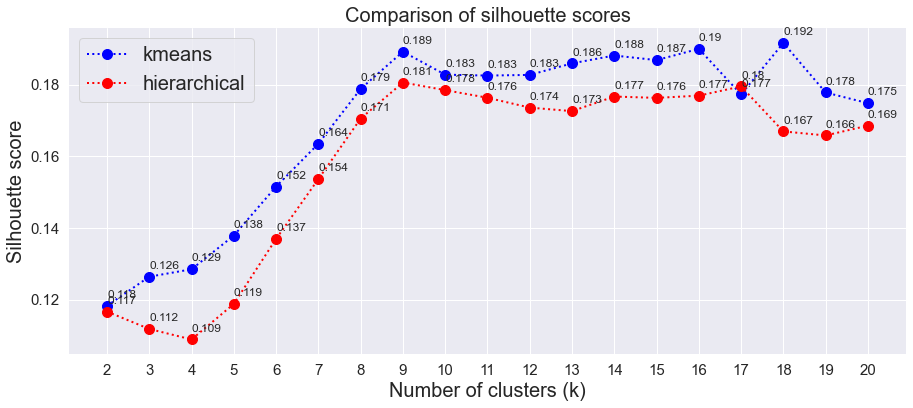

In [194]:
def plot_comparison_by_metric(kmeans_scores, hierarchical_scores, title, ylabel, figsize=(15, 6), loc='upper left'):
    fig, ax = plt.subplots(figsize=figsize)

    plt.plot(clusters, kmeans_scores, marker='.', linestyle='dotted', linewidth=2, markersize=20, color='blue')
    plt.plot(clusters, hierarchical_scores, marker='.', linestyle='dotted', linewidth=2, markersize=20, color='red')
    plt.legend(['kmeans', 'hierarchical'], prop={'size': 20}, loc=loc)
    plt.xlabel('Number of clusters (k)', fontsize=20)
    plt.ylabel(ylabel,  fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize=20)
    plt.xticks(clusters);
    for spine in ax.spines.values():
        spine.set_visible(False)
    amplitude = np.max(kmeans_scores) - np.min(kmeans_scores)
    for i,j in zip(clusters, kmeans_scores):
        ax.annotate(str(round(j, 3)),xy=(i + 0.03 * amplitude, j + 0.03 * amplitude))
    for i,j in zip(clusters, hierarchical_scores):
        ax.annotate(str(round(j, 3)),xy=(i + 0.03 * amplitude, j + 0.03 * amplitude))

plot_comparison_by_metric(silhouette_scores_kmeans,
                          silhouette_scores_hierarchical,
                          "Comparison of silhouette scores",
                          "Silhouette score")

При k = 9 достигается максимум силуэта. То есть оба алгоритма практически правильно определили исходное число кластеров.

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

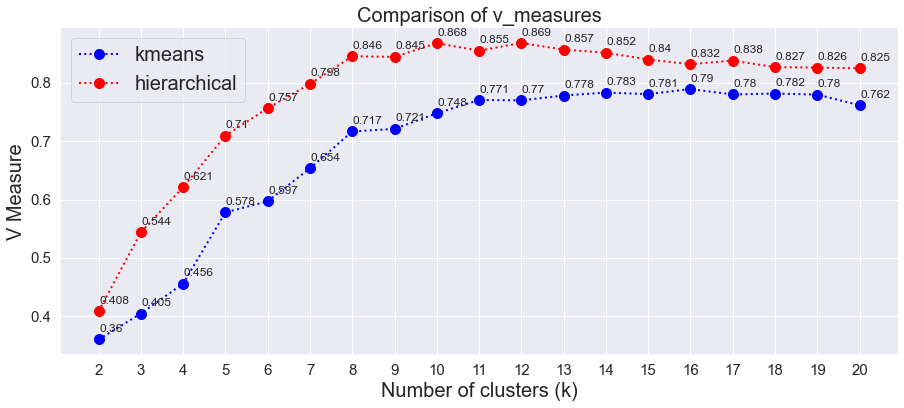

In [195]:
v_measure_kmeans = [metric[2] for metric in entropy_metrics_kmeans]
v_measure_hierarchical = [metric[2] for metric in entropy_metrics_hierarchical]
plot_comparison_by_metric(v_measure_kmeans,
                          v_measure_hierarchical,
                          "Comparison of v_measures",
                          "V Measure")

Максимум v меры для иерархической кластеризации достигается при k=10, а для kmeans при к=11 она тоже почти перестает расти

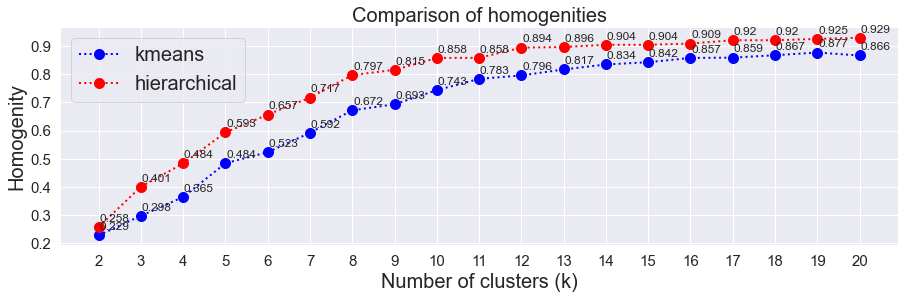

In [196]:
homogenity_kmeans = [metric[0] for metric in entropy_metrics_kmeans]
homogenity_hierarchical = [metric[0] for metric in entropy_metrics_hierarchical]
plot_comparison_by_metric(homogenity_kmeans,
                          homogenity_hierarchical,
                          "Comparison of homogenities",
                          "Homogenity",
                          figsize=(15, 4))

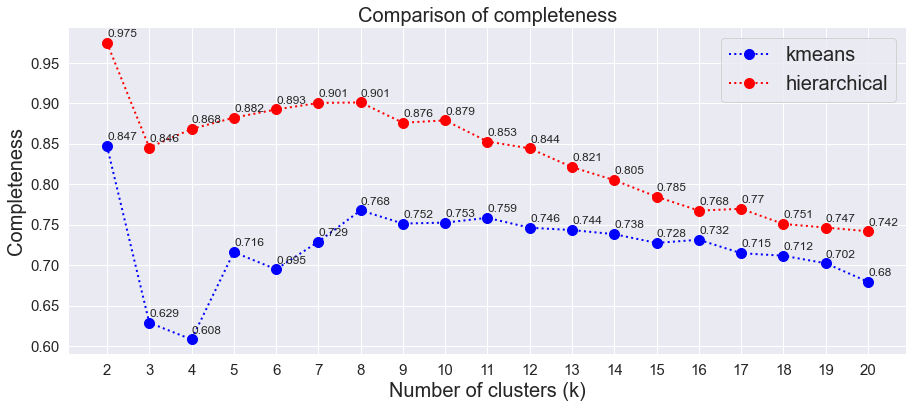

In [197]:
completeness_kmeans = [metric[1] for metric in entropy_metrics_kmeans]
completeness_hierarchical = [metric[1] for metric in entropy_metrics_hierarchical]
plot_comparison_by_metric(completeness_kmeans,
                          completeness_hierarchical,
                          "Comparison of completeness",
                          "Completeness",
                          loc='upper right')

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [198]:
X_2 = TruncatedSVD(n_components=2, random_state=42).fit_transform(X)
X_5 = TruncatedSVD(n_components=5, random_state=42).fit_transform(X)
X_10 = TruncatedSVD(n_components=10, random_state=42).fit_transform(X)
X_20 = TruncatedSVD(n_components=20, random_state=42).fit_transform(X)

print(X.shape, X_2.shape, X_5.shape, X_10.shape, X_20.shape)

(1797, 64) (1797, 2) (1797, 5) (1797, 10) (1797, 20)


In [199]:
decomposed_combinations = [X_2, X_5, X_10, X_20]
n_components = [2, 5, 10, 20]

silhouette_scores_kmeans = []
silhouette_scores_hierarchical = []
v_measure_scores_kmeans = []
v_measure_scores_hierarchical = []

for decomposed in decomposed_combinations:
    
    kmeans = KMeans(n_clusters = 10, n_init = 100).fit(decomposed)
    hierarchical = AgglomerativeClustering(n_clusters = 10).fit(decomposed)
    
    silhouette_scores_kmeans.append(silhouette_score(decomposed, kmeans.labels_))
    silhouette_scores_hierarchical.append(silhouette_score(decomposed, hierarchical.labels_))
    
    v_measure_scores_kmeans.append(v_measure_score(y, kmeans.labels_))
    v_measure_scores_hierarchical.append(v_measure_score(y, hierarchical.labels_))

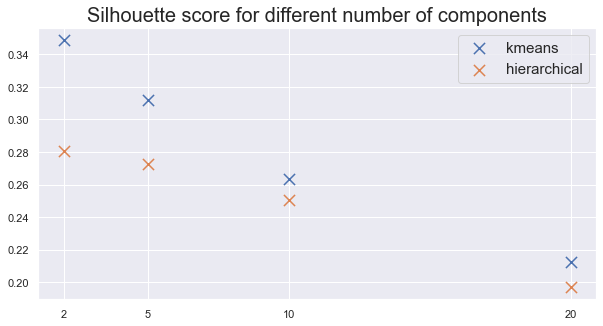

In [200]:
fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(x=n_components, y=silhouette_scores_kmeans, marker='x', s=125)
plt.scatter(x=n_components, y=silhouette_scores_hierarchical, marker='x', s=125)
plt.legend(['kmeans', 'hierarchical'], prop={'size': 15})
plt.xticks(n_components)
plt.title("Silhouette score for different number of components", fontsize=20);

In [201]:
silhouette_table = np.vstack((n_components, silhouette_scores_kmeans, silhouette_scores_hierarchical)).T
print(tabulate(silhouette_table, headers=['Num components', 'KMeans', 'Hierarchical']))

  Num components    KMeans    Hierarchical
----------------  --------  --------------
               2  0.348896        0.280817
               5  0.312253        0.272741
              10  0.26319         0.250712
              20  0.212682        0.197134


**Мы видим, что Silhouette score заметно улучшился после применения метода Truncated SVD.<br/>
Документация говорит о том, что Truncated SVD не центрирует признаки и хорошо работает на разреженных матрицах.<br/>**

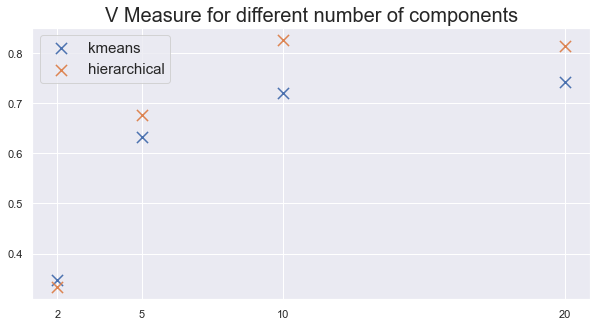

In [202]:
fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(x=n_components, y=v_measure_scores_kmeans, marker='x', s=125)
plt.scatter(x=n_components, y=v_measure_scores_hierarchical, marker='x', s=125)
plt.legend(['kmeans', 'hierarchical'], prop={'size': 15})
plt.xticks(n_components)
plt.title("V Measure for different number of components", fontsize=20);

In [203]:
vmeasure_table = np.vstack((n_components, v_measure_scores_kmeans, v_measure_scores_hierarchical)).T
print(tabulate(vmeasure_table, headers=['Num components', 'KMeans', 'Hierarchical']))

  Num components    KMeans    Hierarchical
----------------  --------  --------------
               2  0.347487        0.333719
               5  0.632502        0.675604
              10  0.720355        0.825975
              20  0.741491        0.814388


**Для V Measure при снижении размерности не удается добиться того же качества, которое было до нее. Таким образом с точки зрения V-measure мы потеряли в качестве работы алгоритма кластеризации.**

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [204]:
X_TSNE = TSNE(n_components=2).fit_transform(X)
X_TSNE.shape

(1797, 2)

In [205]:
def plot_clusters_after_TSNE(X, y):
    """X must be 2-dimensional array after TSNE transformation"""
    fig, ax = plt.subplots(figsize=(14,7))
    plt.scatter(x = X[:, 0], y = X[:, 1], c=y, cmap='ocean')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.title("Clusters after TSNE transformation (n_components=2)", fontsize=20);

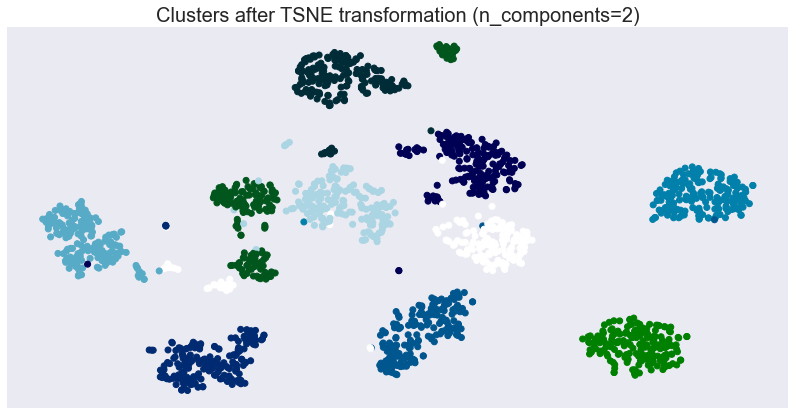

In [206]:
plot_clusters_after_TSNE(X_TSNE, y)

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [207]:
kmeans = KMeans(n_clusters = 10, n_init = 100).fit(X_TSNE)
hierarchical = AgglomerativeClustering(n_clusters = 10).fit(X_TSNE)

print(f"silhouette score for kmeans: {silhouette_score(X_TSNE, kmeans.labels_)}")
print(f"silhouette score for hierarchical: {silhouette_score(X_TSNE, hierarchical.labels_)}")
print(f"v measure for kmeans: {v_measure_score(y, kmeans.labels_)}")
print(f"v measure for hierarchical: {v_measure_score(y, hierarchical.labels_)}")

silhouette score for kmeans: 0.6318383812904358
silhouette score for hierarchical: 0.6333226561546326
v measure for kmeans: 0.8934936213942013
v measure for hierarchical: 0.9209116886685141


Мы видим, что и Silhouette Score и V Measure для tSNE-преобразованных данных стали заметно лучше. Лучше чем на исходных данных и лучше чем после применения TruncatedSVD преобразования.

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

<Figure size 432x288 with 0 Axes>

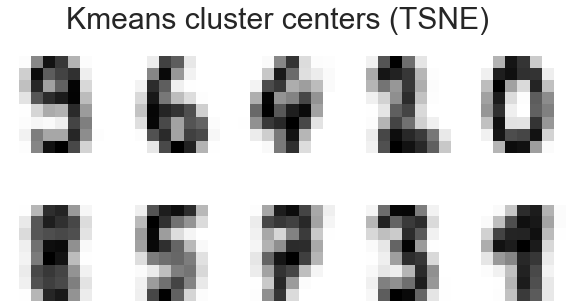

In [208]:
kmeans_centers = calculate_centers(X, kmeans.labels_, N_CLUSTERS, pixels=64)
plot_digits(rows=2,
            columns=5,
            num_of_pictures=10,
            images=kmeans_centers.reshape(10, 8, 8),
            title="Kmeans cluster centers (TSNE)",
            figsize=(10, 5),
            interpolation='nearest');

<Figure size 432x288 with 0 Axes>

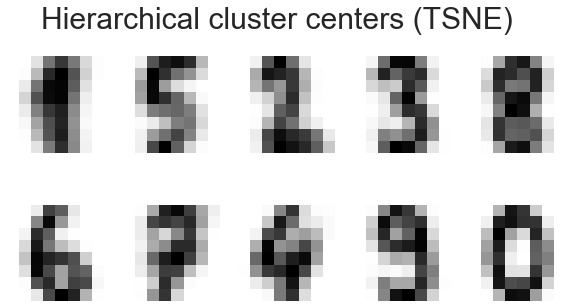

In [209]:
hierarchical_centers = calculate_centers(X, hierarchical.labels_, N_CLUSTERS, pixels=64)
plot_digits(rows=2,
            columns=5,
            num_of_pictures=10,
            images=hierarchical_centers.reshape(10, 8, 8),
            title="Hierarchical cluster centers (TSNE)",
            figsize=(10,5),
            interpolation='bicubic');

Лучшая V Measure получилоась для Иерархической кластеризации вместе с TSNE преобразованием (значение 0.92), лучший Silhouette Score для Иерархической кластеризации вместе с TSNE (значение 0.633). Каждый кластер соответствует отдельной различимой цифре. Цифры размыты, но субъективно лучше чем первые 10 примеров из датасета. Результаты зависят от рандомного состояния (здесь у меня не зафиксированы) и могут немного меняться от запуска к запуску

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

Оба метода дают осмысленную и сравнимую по качеству кластеризацию. На рассмотренном датасете с цифрами в последнем прогоне ноутбука метод Иерархической кластеризации показал чуть лучшие результаты с точки зрения Silhouette Score и V меры. Но в предыдущих запусках в силу того что KMeans рандомизирован результаты иногда менялись и уже KMeans проявлял себя лучше (в этом ноутбуке я не фиксировал рандомное состояние). То есть качество кластеризации зависит не только от выбранного алгоритма, но и от случайного состояния. Оба алгоритма правильно определили число кластеров 10 (иногда с небольшой погрешностью) - то есть на этом значении был достигнут максимум метрики.<br/>

Снижение размерности признакового пространства с помощью выделения главных компонент ухудшило качество.
В то же время применение метода TSNE улучшило наши две метрики качества кластеризации.
Я бы не торопился обобщать эти выводы. Хорошей идеей было бы провести сравнение разных методов снижения размерности на большом числе датасетов, в идеале имеющих целевую разметку чтобы можно было точно оценить качество кластеризации.

Визуально выбранные центры кластеров достаточно неплохо выделили все 10 цифр в примере рассмотренном в этой работе.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [210]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [211]:
print(X.shape, y.shape)

(70000, 784) (70000,)


<Figure size 432x288 with 0 Axes>

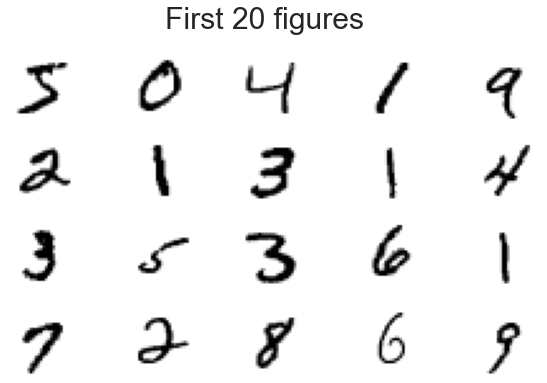

In [212]:
plot_digits(4, 5, 20, X.values.reshape(70000, 28, 28), "First 20 figures", figsize=(10, 6), interpolation=None)

In [213]:
y.value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: class, dtype: int64

In [214]:
for i in range(1, 11):
    print(i, X['pixel' + str(i)].unique())

1 [0.]
2 [0.]
3 [0.]
4 [0.]
5 [0.]
6 [0.]
7 [0.]
8 [0.]
9 [0.]
10 [0.]


Мы видим что первые  10 пикселей никак не отличаются между собой и все равны 0. Найдем все такие пиксели и выбросим их (всего их 65)

In [215]:
no_values_pixels = []
for i in range(1, 785):
    num_of_uniq_values = X['pixel' + str(i)].nunique()
    if num_of_uniq_values == 1:
        no_values_pixels.append('pixel' + str(i))
len(no_values_pixels)

65

In [216]:
X_cleaned = X.drop(columns=no_values_pixels)

In [217]:
X_cleaned.shape

(70000, 719)

Т.к. в предыдущем задании лучше всего работал TSNE попробуем применить его и в этой задаче. Документация к TSNE в SKLearn дает следующие рекомендации:

"It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples."

Матрицы в данных достаточно разреженные, поэтому применим TruncatedSVD с n_components = 50 (по-хорошему стоит попробовать и другие варианты)

In [218]:
X_SVD_50 = TruncatedSVD(n_components=50, n_iter=10, random_state=42).fit_transform(X_cleaned)

In [219]:
X_SVD_50.shape

(70000, 50)

При помощи TSNE снизим размерность до 2 признаков для визуализации и до 3 признаков для эксперимента (надо было бы попробовать больше значений, но работает все не так быстро чтобы увлекаться). 2 признака позволят нам визуализировать кластеры на плоскости, 3 сравнить улучшается ли качество в чуть большем пространстве

In [220]:
%%time
X_TSNE_2 = TSNE(n_components=2, n_jobs=-1).fit_transform(X_SVD_50)

Wall time: 9min 33s


In [221]:
%%time
X_TSNE_3 = TSNE(n_components=3, n_jobs=-1).fit_transform(X_SVD_50)

Wall time: 22min 12s


Для этой задачи не получится использовать алгоритм Иерархической кластеризации, т.к. он имеет оценку по памяти O(n^2) (и не радужную оценку по времени O(n^3).

In [222]:
(70000 * 2) ** 2 / (1024 ** 3)

18.25392246246338

18.2 гб памяти надо чтобы запустить иерархическую кластеризацию на компьютере (это с двумя признаками)

Поэтому используем алгоритм KMeans для этой задачи (точную оценку по памяти надо исследовать, но она явно не квадратичная)

In [223]:
kmeans_tsne2 = KMeans(n_clusters = 10, n_init = 50).fit(X_TSNE_2)
kmeans_tsne3 = KMeans(n_clusters = 10, n_init = 50).fit(X_TSNE_3)

In [224]:
silhouette_score(X_TSNE_2, kmeans_tsne2.labels_)

0.39859986

In [225]:
silhouette_score(X_TSNE_3, kmeans_tsne3.labels_)

0.3366102

In [226]:
v_measure_score(y, kmeans_tsne2.labels_)

0.7868789110152062

In [227]:
v_measure_score(y, kmeans_tsne3.labels_)

0.7735227446010028

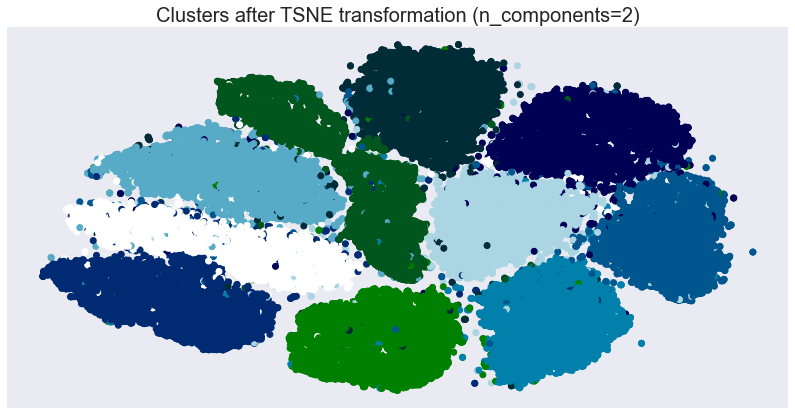

In [228]:
plot_clusters_after_TSNE(X_TSNE_2, [int(value) for value in y.values])

In [229]:
kmeans_centers = calculate_centers(X, kmeans_tsne2.labels_, N_CLUSTERS, pixels=784)

<Figure size 432x288 with 0 Axes>

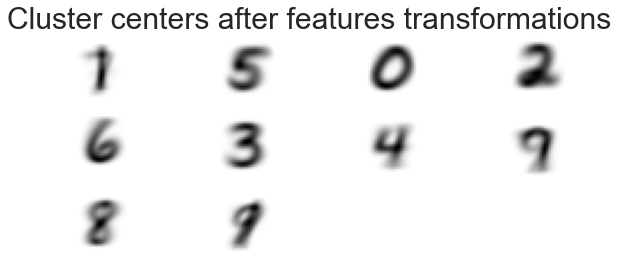

In [230]:
plot_digits(rows=3,
            columns=4,
            num_of_pictures=10,
            images=kmeans_centers.reshape(10, 28, 28),
            title="Cluster centers after features transformations",
            figsize=(10,4))

Попробуем также алгоритм KMeans без всякого преобразования признакового пространства. Для того чтобы понять имели ли они смысл.

In [231]:
kmeans_notransform = KMeans(n_clusters = 10, n_init = 50).fit(X)

In [232]:
silhouette_score(X, kmeans_notransform.labels_)

0.05869201052848778

In [233]:
v_measure_score(y, kmeans_notransform.labels_)

0.4997437873174721

In [234]:
kmeans_no_transform_centers = calculate_centers(X, kmeans_notransform.labels_, N_CLUSTERS, pixels=784)

<Figure size 432x288 with 0 Axes>

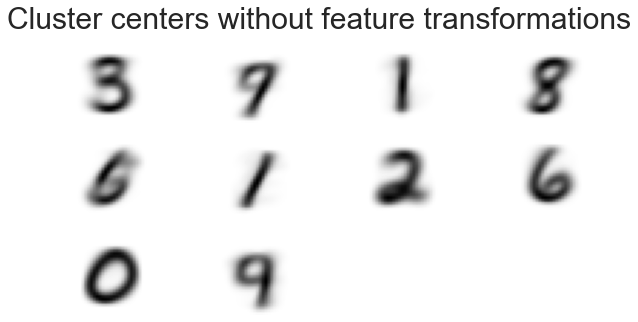

In [235]:
plot_digits(rows=3,
            columns=4,
            num_of_pictures=10,
            images=kmeans_no_transform_centers.reshape(10, 28, 28),
            title="Cluster centers without feature transformations",
            figsize=(10,5))

Мы видим, что с точки зрения метрик качества, преобразования которые мы делали в начале имели смысл. Они улучшили качество по сравнению с простым вариантом применения KMeans. Конечно, это достаточно сырой вариант кластеризации цифр, но цифры после преобразований достаточно четко отделимы. Например, цифра 4 в "сыром" варианте была не отделима, но после преобразования признакового пространства стала видна. Цифры 7 и 9 все еще немного смешаны визуально. Работа по кластеризации должна быть продолжена, но уже не в рамках этого домашнего задания. Имело бы смысл попробовать алгоритм UMAP, внимательнее сделать преобразование исходных признаков, лучше подобрать гиперпараметры и тд (но вычислительно это очень долго и остается в планах на будущее)

# 5. Quiz: Clustering and dimensionality reduction

Бонусом в нотбуке идет мое решение Quiz-а. Так как вопросы сформулированы на английском - так же даются и ответы.

In [236]:
data = np.array([
    [-1, -1],
    [-2, -1],
    [-1, -2],
    [0, 0],
    [2, 1],
    [2, 3]
])

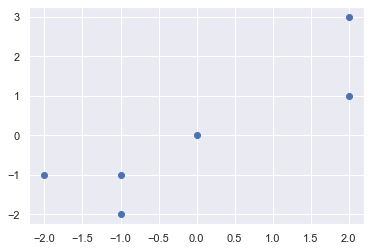

In [237]:
plt.scatter(x=data.T[0, :], y=data.T[1,:]);

## 1. Calculate single-linkage hierarchical clustering of this dataset into 2 clusters:

In [238]:
hierarchical = AgglomerativeClustering(n_clusters = 2, linkage='single').fit(data)

In [239]:
hierarchical.labels_

array([1, 1, 1, 1, 0, 0], dtype=int64)

Answer is :{x₁, x₂, x₃, x₄}, {x₅, x₆}

## 2. Given two initial centers x₁ and x₄, calculate K-means clustering of the dataset. To break ties, assume the point doesn't leave its current cluster when equally close to more than one center.

In [240]:
kmeans = KMeans(n_clusters=2, init=np.array([data[0], data[3]]), n_init=1).fit(data)

In [241]:
kmeans.labels_

array([0, 0, 0, 1, 1, 1])

Let's check this result by manual calculation of KMeans.<br/>
We see graphically that first initialization of centers spllit our clusters half by half x_1, x_2, x_3 and x_4, x_5, x_6

First centers are k1_center = (-1, -1) and k2_center = (0, 0)<br/>

In [242]:
k1_center = np.mean(data[0:3], axis=0)
k1_center

array([-1.33333333, -1.33333333])

In [243]:
k2_center = np.mean(data[3:], axis=0)
k2_center

array([1.33333333, 1.33333333])

After first move, cluster centers move to k1_center = (-1.33, -1.33) and k2_center = (1.33, 1.33)<br/>
Now let's reassign cluster centers based on euclidean distance

In [244]:
for point in data:
    print(point, np.linalg.norm(k1_center - point), np.linalg.norm(k2_center - point))

[-1 -1] 0.47140452079103157 3.299831645537221
[-2 -1] 0.7453559924999299 4.068851871911233
[-1 -2] 0.7453559924999299 4.068851871911233
[0 0] 1.8856180831641267 1.8856180831641267
[2 1] 4.068851871911233 0.7453559924999299
[2 3] 5.467073155618908 1.7950549357115015


We see that first x_1, x_2, x_3 are closer to k_1 center, x_4 has equal distance, x_5 and x_6 are closer to k2_center. By condition of the task we keep x_4 belonging to cluster 2. And algorithm is done.

## 3. Given the hyperparameters of DBSCAN ε=2 and m=2, how many non-noise clusters would be discovered by DBSCAN in the dataset?

In [245]:
dbscan_clustering = DBSCAN(eps=2, min_samples=2, metric='euclidean').fit(data)
dbscan_clustering.labels_

array([0, 0, 0, 0, 1, 1], dtype=int64)

We see two non-noise clusters (not equal to -1 in label)

## 4. More generally, what would be the output of DBSCAN when ε is large and m is small w.r.t. the density of points in a given point cloud?

All points will be grouped together into a single cluster <br/>
Let's check it on our example and also try other combinations of epsilon and m

In [246]:
dbscan_clustering = DBSCAN(eps=5, min_samples=2, metric='euclidean').fit(data)
dbscan_clustering.labels_

array([0, 0, 0, 0, 0, 0], dtype=int64)

If epsilon would be small and m is small all points would be in separate clusters

In [247]:
dbscan_clustering = DBSCAN(eps=0.1, min_samples=1, metric='euclidean').fit(data)
dbscan_clustering.labels_

array([0, 1, 2, 3, 4, 5], dtype=int64)

If epsilon would be small and m is large all points would be noisy

In [248]:
dbscan_clustering = DBSCAN(eps=0.1, min_samples=4, metric='euclidean').fit(data)
dbscan_clustering.labels_

array([-1, -1, -1, -1, -1, -1], dtype=int64)

If both epsilon and m are large all points could be either in one cluster or all noisy (if m > total number of points). It depends on m and total amount of points

In [249]:
dbscan_clustering = DBSCAN(eps=4, min_samples=6, metric='euclidean').fit(data)
dbscan_clustering.labels_

array([0, 0, 0, 0, 0, 0], dtype=int64)

In [250]:
dbscan_clustering = DBSCAN(eps=4, min_samples=7, metric='euclidean').fit(data)
dbscan_clustering.labels_

array([-1, -1, -1, -1, -1, -1], dtype=int64)

## 5. Given the clustering {x₁, x₂, x₃}, {x₄, x₅, x₆}, calculate silhouette averaged over all points:

In [251]:
# let's fix clustering
labels = np.array([0, 0, 0, 1, 1, 1])

In [252]:
score = silhouette_score(data, labels, metric='euclidean')
score

0.45993283428643883

In [253]:
round(score, 2)

0.46

## 6. Slope of the first principal component in the dataset is approximately:

In [254]:
data

array([[-1, -1],
       [-2, -1],
       [-1, -2],
       [ 0,  0],
       [ 2,  1],
       [ 2,  3]])

In [255]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1).fit(data)
pca.components_

array([[0.67944959, 0.73372219]])

In [256]:
angle = np.degrees(np.arctan(pca.components_[0, 1] / pca.components_[0, 0]))
angle

47.19935267749778

C:\Users\Mi\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


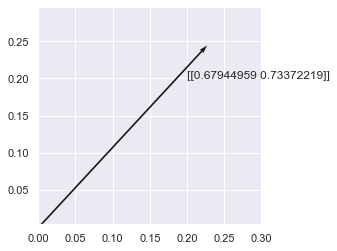

In [257]:
sns.set()

# origin for arrow
X = np.array((0))
Y= np.array((0))

# X and Y coordinates for arrpw
U = np.array((pca.components_[0, 0]))
V = np.array((pca.components_[0, 1]))

fig, ax = plt.subplots(figsize=(4, 4))
q = ax.quiver(X, Y, U, V, units='xy', scale=3)
ax.axis('equal')

plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
ax.annotate(pca.components_, xy=(0.2, 0.2));

We see both graphically and analytically that angle is 47.2 degrees.

## 7. What would be the projection of x₆ onto the first principal component?

In [258]:
pca.transform(data)

array([[-1.41317178],
       [-2.09262138],
       [-2.14689397],
       [ 0.        ],
       [ 2.09262138],
       [ 3.56006575]])

We see that proection of x_6 on PCA is 3.56

## 8. Which of the following nonlinear 1-dimensional projections of the dataset preserves pairwise distances between the points (in the sense of multidimensional scaling objective) as good as possible?

In [259]:
# distances will be calculated twice because of symmetry. but as it's calculated for everything it doesn't matter
pairwise_distance = np.zeros((6, 6))
for i in range(6):
    for j in range(6):
        pairwise_distance[i, j] = np.linalg.norm(data[i] - data[j])

In [260]:
pairwise_distance.shape

(6, 6)

In [261]:
projection1 = np.array([-1.34, -2.46, -1.98, 0.00, 2.09, 3.68])
projection2 = np.array([-1.34, 1.98, -2.46, 0.00, 2.09, 3.68])
projection3 = np.array([-1.67, -1.65, -2.46, 0.00, 2.09, 3.68])
projection4 = np.array([-1.67, -2.46, -1.65, 0.00, 2.09, 3.68])

In [262]:
def calculate_projection_distances(projection):
    projection_distance = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            projection_distance[i, j] = np.linalg.norm(projection[i] - projection[j])
    return projection_distance

distances_projections = list(map(calculate_projection_distances, [projection1, projection2, projection3, projection4]))

In [263]:
def preserved_distance(original_distances, projection_distances):
    return np.sum((original_distances - projection_distances) ** 2)

for index, projection in enumerate(distances_projections, 1):
    print(index, preserved_distance(pairwise_distance, projection))

1 3.325395385308738
2 99.5490208317241
3 6.00558413251297
4 5.826095835524277


We see that first projection preserves distances the best (gives us a minimum in distances before and after transformation)